In [1]:
import gc
from pathlib import Path
from typing import Tuple

import cv2
import glow
import matplotlib.pyplot as plt
import numpy as np
from glow.io import read_tiled
from ipywidgets import interact
from tqdm import tqdm

In [2]:
# ti = read_tiled(Path("../27903-14 [2013] PROST-009.svs"))
ti = read_tiled(Path("../CMU-1-JP2K-33005.svs"))
ti, ti.shape

(_TiffImage('..\CMU-1-JP2K-33005.svs', shape=(32893, 46000, 3), scales=(1, 4, 16)),
 (32893, 46000, 3))

In [3]:
ti.dzi()

_Dzi(slide=_TiffImage('..\CMU-1-JP2K-33005.svs', shape=(32893, 46000, 3), scales=(1, 4, 16)), offset=(0, 0), size=(32893, 46000), tile=256)

<ipython-input-4-eaa23721733c>:2 block done in 262ms
Task done: +5.27MiB


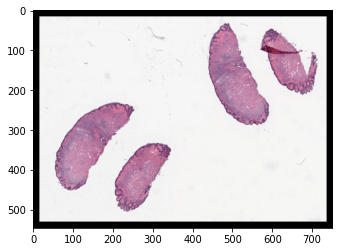

In [4]:
with glow.memprof(), glow.timer():
    arr = ti[-1024:ti.shape[0]+1024:64, -1024:ti.shape[1]+1024:64].view()
    # arr = ti[-1024:ti.shape[0]+1024:10, -1024:ti.shape[1]+1024:10].view()
    # arr = ti[:1024, :1024].view()
    # arr = ti[:240, :240].view()
# while True:
#     with glow.memprof(), glow.timer():
#         for _ in range(1000):
#             ti[-1024:ti.shape[0]+1024:100, -1024:ti.shape[1]+1024:100].view()
#         gc.collect()
plt.imshow(arr)
plt.show()

In [5]:
@interact(y=(-4096, ti.shape[0], 1024),
          x=(-4096, ti.shape[1], 1024),
          scale=(1, 32))
def show(y, x, scale):
    arr = ti[y:y+4096:scale, x:x+4096:scale].view()
    plt.imshow(arr, cmap='gray')
    plt.show()

interactive(children=(IntSlider(value=14336, description='y', max=32893, min=-4096, step=1024), IntSlider(valu…

In [6]:
# Some kernel testing
cell = 10
over = 4

pad = np.arange(0.5, 0.5 + over) / over
kern = np.r_[pad, np.ones(cell-over), pad[::-1]].astype('f4')
(kern, kern[-over:] + kern[:over])

(array([0.125, 0.375, 0.625, 0.875, 1.   , 1.   , 1.   , 1.   , 1.   ,
        1.   , 0.875, 0.625, 0.375, 0.125], dtype=float32),
 array([1., 1., 1., 1.], dtype=float32))

In [7]:
def mask_drop_peaks(image, ksize=17, vmin=2, vmax=227):
    if image.ndim == 3:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    for _ in range(3):
        image = cv2.medianBlur(image, ksize)
    return cv2.inRange(image, vmin, vmax).clip(0, 1)


def mask_drop_plateau(image, ksize=15):
    if image.ndim == 3:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    scale = ksize / 4 ** ksize
    image = cv2.Laplacian(image, cv2.CV_32F, ksize=ksize, scale=scale)
    
    image = (np.abs(image) > 1).astype('u1')

    pattern = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (ksize, ksize))
    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, pattern)

    return cv2.medianBlur(image, ksize)


def get_mask(slide) -> Tuple[np.ndarray, np.ndarray]:
    mini, scale = slide.thumbnail()
    # scale = slide.scales[-1]
    # mini = slide[::scale, ::scale].view()

    s = 16
    mini = np.pad(mini, [(s, s), (s, s), (0, 0)], mode='reflect')

    mask = mask_drop_peaks(mini, vmin=11, vmax=214)
    mask &= mask_drop_plateau(mini)

    mask = mask[s:-s, s:-s]
    return mask, scale

55it [00:04, 11.89it/s]
Reading done in 4.63s


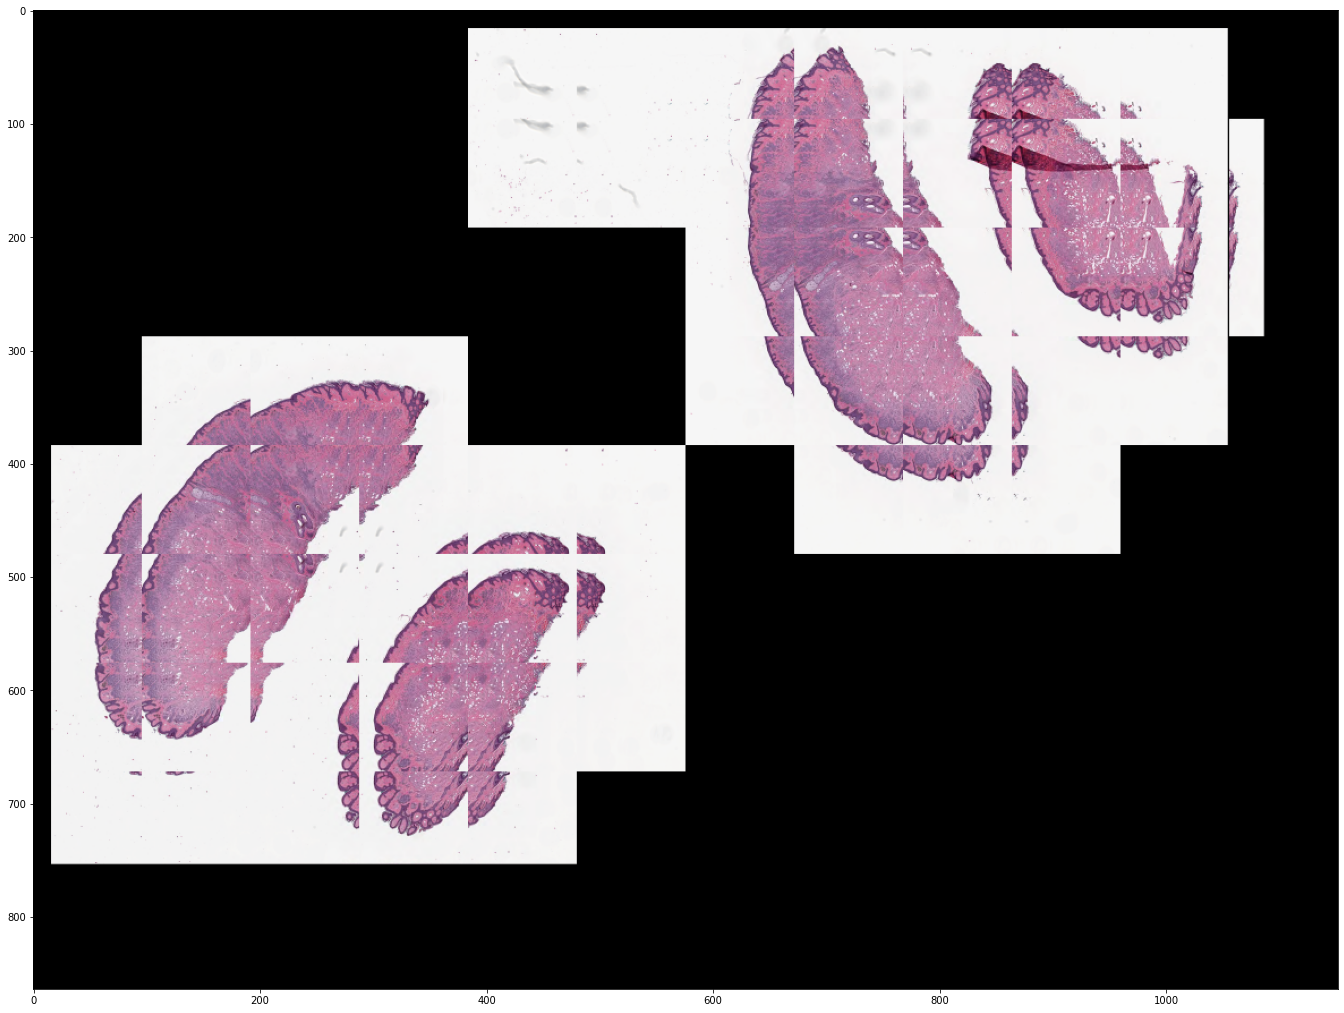

In [8]:
import numpy as np
from glow.util import Mosaic


def process(tile):
    return cv2.medianBlur(image, 15)


mask, m_scale = get_mask(ti)
m = Mosaic(ti, 4096, overlap=2048).filter_(mask, m_scale)

with glow.timer('Reading'):
    max(tqdm(m.read(scale=4)))

white = np.zeros((10, 10))
# _, axes = plt.subplots(*m.ishape, figsize=[2 * s for s in m.ishape[::-1]])
# for ax in axes.ravel():
#     ax.set_xticks([])
#     ax.set_yticks([])
#     ax.imshow(white)
 
ixs, tiles = zip(*m.read(scale=64))
th, tw, _ = tiles[0].shape
canvas = np.zeros((m.ishape[0] * th, m.ishape[1] * tw, 3), dtype='u1')
for (iy, ix), tile in zip(ixs, tiles):
    canvas[iy * th: iy * th + th, ix * tw: ix * tw + tw:] = tile

plt.figure(figsize=[2 * s for s in m.ishape[::-1]])
plt.imshow(canvas)
plt.show()

# for (iy, ix), tile in m.read(scale=64):
#     axes[iy, ix].imshow(tile)
# plt.show()

In [9]:
raise

RuntimeError: No active exception to reraise

In [12]:
@interact(f=(0, 6, 0.25))
def show(f):
    f = 2 ** f
    p = ti[5500:8500:f, 20000:26000:f].view()
    plt.figure(figsize=(16, 8))
    plt.suptitle(f'{p.shape} - (1:{p.shape[1]/p.shape[0]:.3f}) - {f:.2f}X')
    plt.imshow(p, interpolation='lanczos')
    plt.show()

interactive(children=(FloatSlider(value=3.0, description='f', max=6.0, step=0.25), Output()), _dom_classes=('w…

In [10]:
import gc
import random
from pathlib import Path

from glow import memprof, timer
from glow.io import read_tiled, _tiled
from torchvision.transforms import functional as F

_tiled._setup_libs()

ps = 4096
st = 4096
s = 4

names = [*Path('..').glob('*.svs')][:1]
print(len(names))

# read_tiled.cache.clear()
with memprof(), timer():
    for name in names:
        F.to_tensor(read_tiled(name)[::s, ::s].view())
print(read_tiled.cache)

# read_tiled.cache.clear()
with memprof(), timer():
    for name in names:
        ti_ = read_tiled(name)
        for y in range(0, ti_.shape[0], st):
            for x in range(0, ti_.shape[1], st):
                F.to_tensor(ti_[y: y+ps: s, x: x+ps: s].view())
        del ti_
print(read_tiled.cache)

ModuleNotFoundError: No module named 'torchvision'

In [10]:
import cv2
import numpy as np

class ArrayLike:
    def __array__(self):
        return np.arange(25, dtype='u1').reshape(5, 5)

arr = ArrayLike()

print('pure numpy')
x1 = np.add(arr, 5)
print(x1)

print('cv2 with np.array')
x2 = cv2.add(np.array(arr), 5)
print(x2)

assert np.allclose(x1, x2)

print('plain cv2')
cv2.add(arr, 5)

pure numpy
[[ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]
 [20 21 22 23 24]
 [25 26 27 28 29]]
cv2 with np.array
[[ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]
 [20 21 22 23 24]
 [25 26 27 28 29]]
plain cv2


TypeError: Expected Ptr<cv::UMat> for argument 'src1'